In [22]:
import pandas as pd
import numpy as np
import pickle as pkl

#modeling
from sklearn.model_selection import train_test_split
import xgboost as xgb
#from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, SCORERS
from imblearn.over_sampling import ADASYN, SMOTE
from imblearn.under_sampling import RandomUnderSampler
# from sklearn.preprocessing import StandardScaler
# from sklearn.linear_model import LogisticRegression
# from sklearn.neighbors import KNeighborsClassifier
from classification_functions import logistic_model_scaled, knn_classification_scaled, conf_matrix, plot_roc, decision_tree
from classification_functions import random_forest, x_GBoost #multinomial_nb

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [23]:
#set the rc parameters
plt.style.use('ggplot')
plt.rc('font', size=10)
#SCORERS.keys()

Load data

In [24]:
df = pd.read_pickle('../Data/survey_data_cleaned2.pkl')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56208 entries, 4 to 56166
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   Hobbyist                56208 non-null  object  
 1   Age                     56208 non-null  float64 
 2   Age1stCode              56208 non-null  float64 
 3   EdLevel                 56208 non-null  object  
 4   Ethnicity               56208 non-null  object  
 5   Gender                  56208 non-null  object  
 6   OpSys                   56208 non-null  category
 7   UndergradMajor          56208 non-null  object  
 8   YearsCode               56208 non-null  float64 
 9   YearsCodePro            56208 non-null  float64 
 10  database_count          56208 non-null  int64   
 11  Region                  56208 non-null  object  
 12  back-end                56208 non-null  object  
 13  full-stack              56208 non-null  object  
 14  front-end             

In [25]:
print(len(df))
df['OpSys'].value_counts()

56208


Windows        25868
MacOS          15588
Linux-based    14752
Name: OpSys, dtype: int64

### EDA

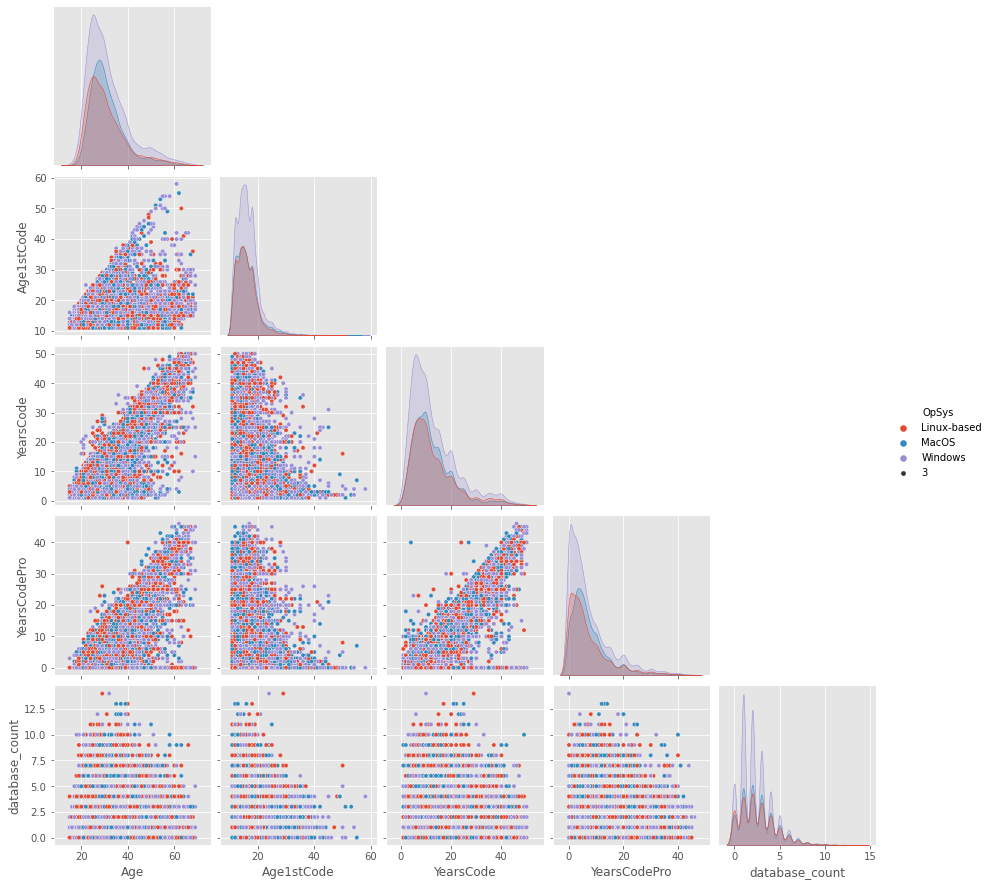

In [45]:
plt.rcParams['figure.figsize']=(1,2)
#We want to pick one feature to start that separates the two cases.
sns.pairplot(df[['OpSys', 'Age', 'Age1stCode', 'YearsCode', 'YearsCodePro', 'database_count']], 
             corner=True, plot_kws={'size': 3}, hue='OpSys')

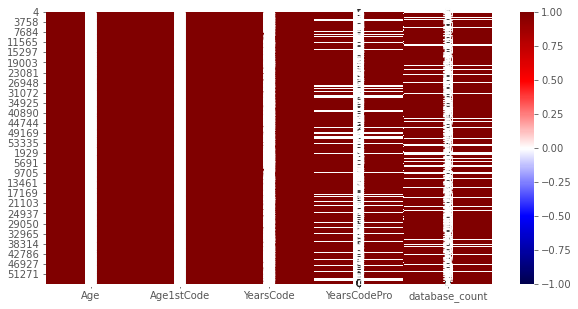

In [48]:
plt.figure(figsize=(10,5))
sns.heatmap(df[[ 'Age', 'Age1stCode', 'YearsCode', 'YearsCodePro', 'database_count']], cmap="seismic", annot=True, vmin=-1, vmax=1);

<ipython-input-37-aae7c1671583>:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


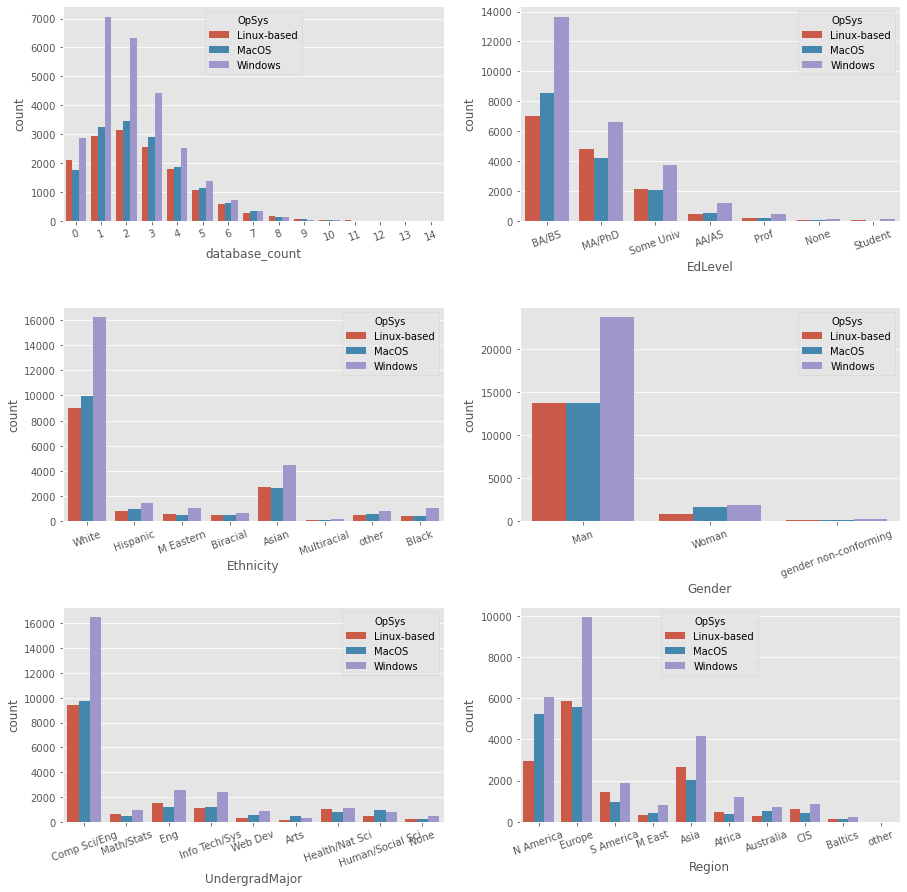

In [37]:
categorical_columns = ['database_count', 'EdLevel', 'Ethnicity', 'Gender', 'UndergradMajor', 'Region']
fig, ax =plt.subplots(3,2, gridspec_kw={'hspace': 0.4, 'wspace': 0.2}, figsize=(15,15))
idx = 0
for x in range(0,3):
    for y in range(0,2):
        sns.countplot(x = categorical_columns[idx], hue='OpSys', data=df, ax=ax[x,y])
        ax[x,y].set_xticklabels(ax[x,y].get_xticklabels(),rotation=20)
        idx= idx+1
fig.show()

<ipython-input-38-9c9b35b1cc88>:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


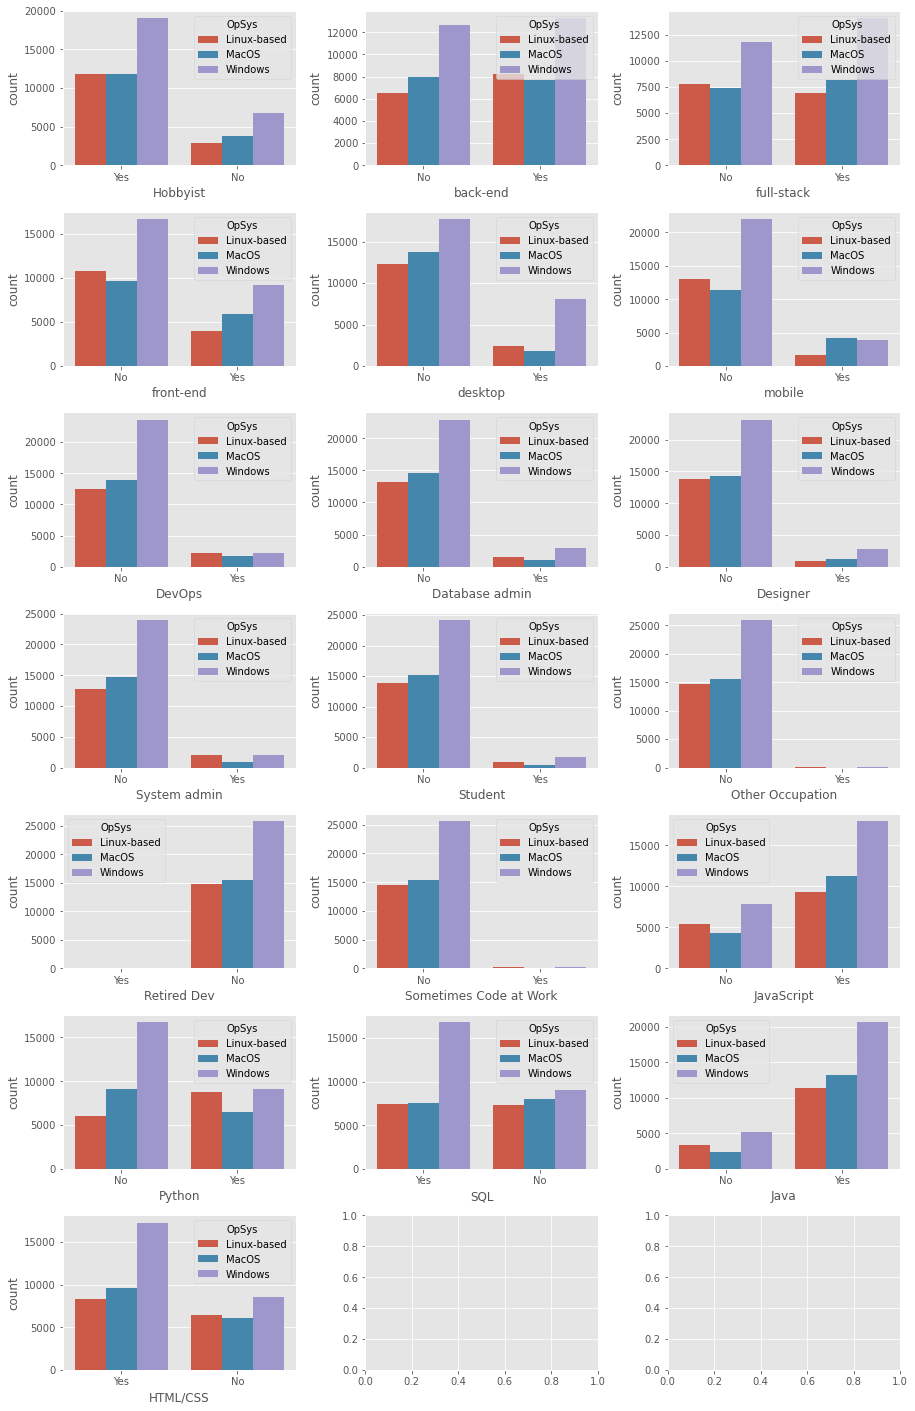

In [38]:
binary_columns = ['Hobbyist', 'back-end', 'full-stack', 'front-end', 'desktop', 'mobile', 'DevOps', 'Database admin', 'Designer',
                 'System admin', 'Student', 'Other Occupation', 'Retired Dev','Sometimes Code at Work',
                 'JavaScript', 'Python', 'SQL', 'Java', 'HTML/CSS']
fig, ax =plt.subplots(7,3, gridspec_kw={'hspace': 0.3, 'wspace': 0.3}, figsize=(15,25))
idx = 0
for x in range(0,7):
    for y in range(0,3):
        if idx >= 19:
            break
        sns.countplot(x = binary_columns[idx], hue='OpSys', data=df, ax=ax[x,y])
        idx= idx+1
fig.show()

### Baseline Modeling

Perform basline modeling on only a few fatures

In [29]:

# do not include Age1stCode, YearsCodePro, ethnicity, hobbyist, other occupation, retired dev, sometimes code at work
X = df[['Age', 'YearsCode', 'database_count',
         'EdLevel', 'Gender', 'UndergradMajor', 'Region', 
         'back-end', 'full-stack', 'front-end', 'desktop', 'mobile', 'DevOps', 'Database admin', 
        'Designer','System admin', 'Student', 
       'JavaScript', 'Python', 'SQL', 'Java', 'HTML/CSS']]
y = df['OpSys']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

X_train_enc=pd.get_dummies(X_train, drop_first=True)
X_test_enc=pd.get_dummies(X_test, drop_first=True)
#X.info()

In [30]:
#plt.rc('font', size=12)
lm = logistic_model_scaled(X_train_enc, y_train)
#conf_matrix(lm_mn, X_test, y_test)

Logistic Regression with params:

{'penalty': 'l2', 'max_iter': 10000, 'C': 0.1}
Accuracy: 0.55,
Precision score: 0.528,
Recall score: 0.501,
f1 score: 0.504,
ROC AUC score: 0.71,
Negative Log-loss: -0.946,



In [31]:
knn = knn_classification_scaled(X_train_enc, y_train)
#conf_matrix(knn, X_test, y_test)

KNN with params:

{'n_neighbors': 5}
Accuracy: 0.541,
Precision score: 0.52,
Recall score: 0.517,
f1 score: 0.518,
ROC AUC score: 0.724,
Negative Log-loss: -2.739,



In [32]:
dt = decision_tree(X_train_enc, y_train)

Decision Tree with params:

{'max_features': 'auto', 'max_depth': 14, 'criterion': 'entropy'}
Accuracy: 0.558,
Precision score: 0.546,
Recall score: 0.517,
f1 score: 0.527,
ROC AUC score: 0.73,
Negative Log-loss: -2.079,



In [46]:
rf = random_forest(X_train_enc, y_train)

KeyboardInterrupt: 

In [33]:
xgb = x_GBoost(X_train_enc, y_train)

/Users/racheldilley/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/racheldilley/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/racheldilley/opt/anaconda3/lib/python3.8/site-pac

XGBoost:

Accuracy: 0.8094,
Precision score: 0.802,
Recall score: 0.7988000000000001,
f1 score: 0.8004,
ROC AUC score: 0.9018,
Negative Log-loss: 1.1944000000000001,



XGboost performed the best with an f1 score of 0.8. XGBoost will be used for our final model